Neural Machine Translator Using Transformers
==

## Environment Preparation

In [1]:
!pip uninstall -y -q tensorflow keras
!pip install tensorflow keras
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install tensorflow_text
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 18.9 MB/s eta 0:00:00


## Initializing Data

Loads a machine translation dataset from TensorFlow Datasets, specifically the "ted_hrlr_translate/pt_to_en" dataset. This dataset contains translations of phrases from Portuguese (PT) to English (EN). It loads the data, including both the training and validation sets, with the associated metadata.

In [27]:
import tensorflow_datasets as tfds

In [28]:
ds = 'ted_hrlr_translate/pt_to_en'
data, meta = tfds.load(ds, with_info=True, as_supervised=True)
train, val = data["train"], data["validation"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.SQUSJZ_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.SQUSJZ_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.SQUSJZ_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [72]:
for pt, en in val.batch(1).take(1):
    print("PT: ", "".join([p.decode("utf8") for p in pt.numpy()]))
    print("EN: ", "".join([e.decode("utf8") for e in en.numpy()]))

PT:  tinham comido peixe com batatas fritas ?
EN:  did they eat fish and chips ?


## Data Preparation

a machine translation pipeline is being setup by downloading a pre-trained tokenizer model for Portuguese-to-English translation. It loads the tokenizer and uses it to tokenize the Portuguese and English sentences from the validation set, calculating the length of tokenized sequences for both languages. The distribution of token lengths is visualized using a histogram.

The dataset is batched, shuffled, and preprocessed with TensorFlow's data pipeline optimizations. Finally, the pipeline is ready for model training, with tokenized batches for both languages, split into inputs and labels.

In [30]:
import tensorflow as tf
import tensorflow_text

In [31]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [32]:
!mv /content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter .
!rm -rf /content/ted_hrlr_translate_pt_en_converter_extracted

In [33]:
tokenizers = tf.saved_model.load(model_name)
" ".join([i for i in dir(tokenizers.en) if not i.startswith("_")])

'detokenize get_reserved_tokens get_vocab_path get_vocab_size lookup tokenize tokenizer vocab'

In [34]:
print("RAW: ", "".join([e.decode("utf8") for e in en.numpy()]))
encoded = tokenizers.en.tokenize(en)
print("Encoded: ", encoded.to_list())
dencoded = tokenizers.en.detokenize(encoded)
print("Decoded: ", [i.decode("utf8") for i in dencoded.numpy()])
tokens = tokenizers.en.lookup(encoded)
print("Tokens: ", [j.decode("utf8") for i in tokens.numpy() for j in i])

RAW:  did they eat fish and chips ?
Encoded:  [[2, 149, 83, 776, 1269, 72, 3453, 30, 3]]
Decoded:  ['did they eat fish and chips ?']
Tokens:  ['[START]', 'did', 'they', 'eat', 'fish', 'and', 'chips', '?', '[END]']


In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
lengths = []

for pt, en in val.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

lengths = np.concatenate(lengths)

..

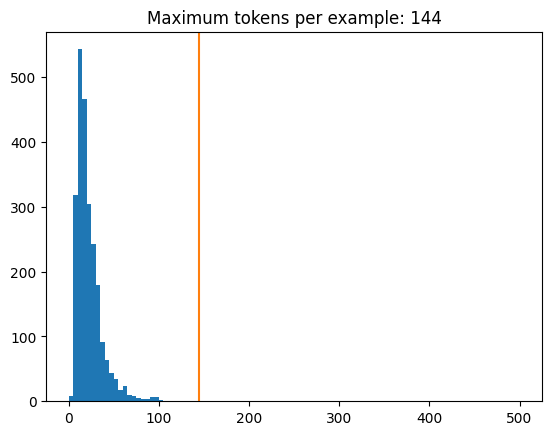

In [37]:
plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [73]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)[:, :MAX_TOKENS].to_tensor()
    en = tokenizers.en.tokenize(en)[:, :(MAX_TOKENS + 1)]

    en_inputs = en[:, :-1].to_tensor()
    en_labels = en[:, 1:].to_tensor()

    return (pt, en_inputs), en_labels

In [74]:
BUFFER_SIZE = 500
BATCH_SIZE = 16

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [75]:
train_batches = make_batches(train)
val_batches = make_batches(val)

In [76]:
(pt, en), en_labels = next(iter(train_batches.take(1)))
print("PT Shape: ", pt.shape)
print("EN Shape: ", en.shape)
print("EN-Labels Shape: ", en_labels.shape)
print(pt[0][:10])
print(en[0][:10])
print(en_labels[0][:10])

PT Shape:  (16, 41)
EN Shape:  (16, 44)
EN-Labels Shape:  (16, 44)
tf.Tensor([  2  10 178  11   3   0   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([  2  10 189  11   0   0   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([ 10 189  11   3   0   0   0   0   0   0], shape=(10,), dtype=int64)


## Transformer Components

Now, essential components of a Transformer model are being defined for machine translation.

### Positional Encoding

This custom layer combines token embeddings with positional encodings. It takes the input sequence, embeds it using a standard embedding layer, and adds the positional encodings to these embeddings.

In [42]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]
  depths = np.arange(depth)[np.newaxis, :]/depth

  angle_rates = 1 / (10000**depths)
  angle_rads = positions * angle_rates

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


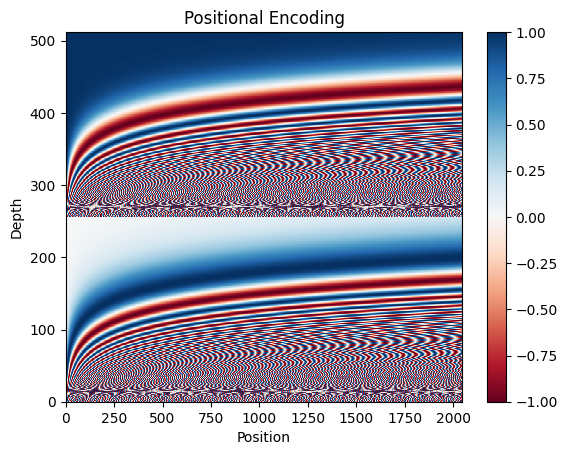

(0.0, 1.0)

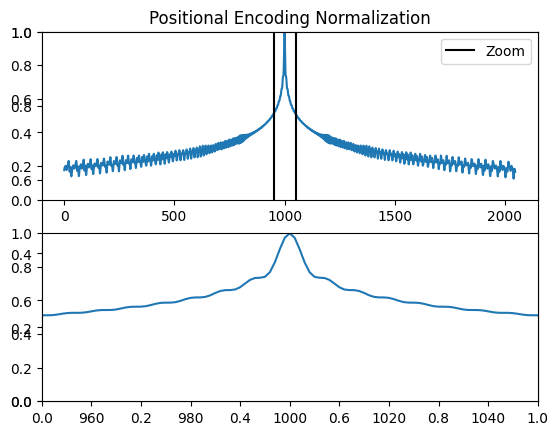

In [43]:
pos_encoding = positional_encoding(length=2048, depth=512)
plt.title("Positional Encoding")
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.title("Positional Encoding Normalization")
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [44]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [45]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

### Attention Layers

In [46]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Cross Attention

The role of cross-attention is to allow the decoder to attend to the encoder’s output when generating each token in the sequence.

The query, represented by `x`, refers to the target sequence that the decoder is working on. It contains the current state of the decoder, which is based on the tokens already generated.

The context, represented by `context`, refers to the encoder’s output. This is the sequence of encoded information that comes from processing the input (source sequence) through the encoder.

The attention mechanism computes a weighted sum of the context tokens, based on how much each context token should contribute to the current token being generated in the target sequence.

In [47]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

#### Global Self-Attention

The Global Self-Attention mechanism allows each token in the sequence to attend to every other token, capturing long-range dependencies and relationships across the entire sequence.

The query (`x`) refers to the token that is currently being processed (or the current token in the sequence). The key and value also represent the same sequence, meaning that every token is both seeking information from and contributing information to every other token in the sequence.

In [48]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

#### Causal Self-Attention

Causal self-attention is a mechanism that allows each token in a sequence to attend only to the tokens before it (and itself) when generating the next token in an autoregressive model. This ensures that the model makes predictions based on previous context without "cheating" by using future tokens.

This layer does a similar job as the global self-attention layer, for the output sequence.

In [49]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### Feedforward

The FeedForward layer is a key component of the Transformer architecture, applied in both the encoder and decoder. It is a point-wise feed-forward network, meaning it operates independently on each position in the sequence (token) rather than on the entire sequence at once.

`d_model` determines the dimensionality of the input and output of the layer. This represents the size of the feature vectors for each token in the sequence. Another important parameter is `dff`, which refers to the number of units in the hidden layer of the feed-forward network. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the output units to zero during each training step. The `dropout_rate` determines what fraction of these units are dropped.

In [50]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

### Encoder

The encoder in the Transformer architecture is responsible for processing the input sequence and generating a rich, context-aware representation.

The `d_model` parameter represents the dimensionality of the model, meaning the size of the input and output vectors that each layer will process. The `num_heads` parameter controls the number of attention heads in the self-attention mechanism. The `dff` parameter refers to the dimensionality of the feedforward network (FFN) that follows the attention mechanism. The `dropout_rate` is a regularization technique used to reduce overfitting during training. It randomly "drops" (sets to zero) a fraction of the neurons during training.

In [51]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


In [52]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

### Decoder

The decoder is responsible for generating the output sequence, using the context-rich representations produced by the encoder. The parameters in the layer are similar to the params in the encoder class.

In [53]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)
    return x

In [54]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

## Building Transformer

In the Transformer class, everything comes together to form a complete sequence-to-sequence model. It integrates the encoder and decoder components, which were defined earlier, to handle the entire processing flow.

The `num_layers` parameter defines how deep the model is by specifying how many layers of the encoder and decoder the model will contain. The `input_vocab_size` and `target_vocab_size` are parameters that define the size of the vocabulary for the input and output sequences, respectively.

In [55]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x  = inputs

    context = self.encoder(context)

    x = self.decoder(x, context)

    logits = self.final_layer(x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits


In [56]:
num_layers = 2
d_model = 8
dff = 8
num_heads = 2
dropout_rate = 0.1

In [57]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

## Training Transformer

Now, the model will be trained against the training batch created

### Learning Rate x Optimizer

The custom learning rate schedule is designed to adjust the learning rate based on the current training step.

In [58]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [59]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

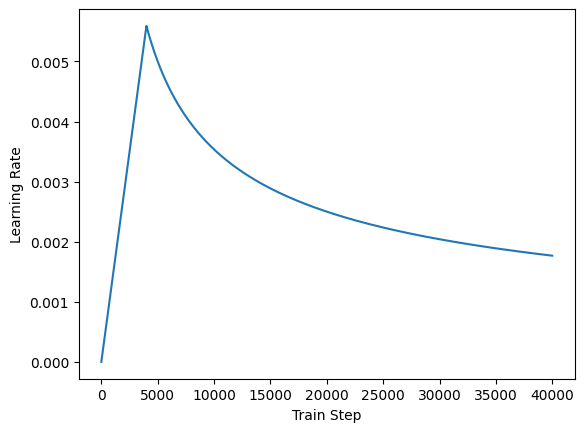

In [60]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Masked Loss

In the context of sequence processing tasks like machine translation, it's common to encounter padded sequences. These padding tokens are added to the sequences to ensure that all input or output sequences in a batch have the same length. However, the padding tokens do not carry meaningful information and should not influence the loss or accuracy calculation.

To handle this, masking is applied to ignore the padding tokens during loss and accuracy calculations.

In [61]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Compiling model

The model is compiled using the `masked_loss` as a metric for the backpropagation and the optimizer is also inserted. The summary can't output the shapes of each layer as the model is only built when the training begins.

In [80]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [70]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Actual Training (GPU)

After the training all the weights were saved to capture the state of the model.

In [ ]:
%%timeit
transformer.fit(train_batches,
                epochs=1,
                validation_data=val_batches)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.


247/810 ━━━━━━━━━━━━━━━━━━━━ 1:04:58 7s/step - loss: 8.8197 - masked_accuracy: 8.8655e-04

In [91]:
transformer.save_weights("model.weights.h5")

## Making inferences

After training, the model is ready to make inferences.

In [82]:
sample_inputs, _ = next(iter(train_batches))
transformer(sample_inputs)
transformer.load_weights("model.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.


### Creating translator

The Translator class facilitates the process of making inferences to the model. The class handles loading the pre-trained model, tokenizing input text, and generating translations from the source to the target language.`transformer` specifies the path to the pre-trained transformer model, `tokenizers` points to the associated tokenizer for text processing. The `max_length` parameter sets the maximum token limit for input sequences,wpreventing memory issues.

In [85]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())

    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [86]:
translator = Translator(tokenizers, transformer)

### Testing

In [87]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [102]:
pt, en = next(it)
print(en.numpy(), pt.numpy())

b'i was always worried about being caught and sent back .' b'estava sempre preocupado em ser apanhado e enviado de volta .'


In [105]:
it = iter(val)
for i in range(10):
  sentence, ground_truth = [i.numpy() for i in next(it)]
  ground_truth = 'i want to know if the model is working as it should .'

  translated_text, translated_tokens, attention_weights = translator(
      tf.constant(sentence))
  print_translation(sentence.decode('utf8'), translated_text, ground_truth)
  print()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/lo

Input:         : tinham comido peixe com batatas fritas ?
Prediction     : we can be a lot of the spro ( laughter spro ( laughter s - spro
Ground truth   : i want to know if the model is working as it should .

Input:         : estava sempre preocupado em ser apanhado e enviado de volta .
Prediction     : i was not to be a lot of the s - s - sprop .
Ground truth   : i want to know if the model is working as it should .

Input:         : escolhi um com o tom de pele de uma lagosta com um escaldão .
Prediction     : i got a lot of the spro of the s - more in the s - more in the new york .
Ground truth   : i want to know if the model is working as it should .

Input:         : mas eu penso que isto é claramente falso .
Prediction     : but i think that .
Ground truth   : i want to know if the model is working as it should .

Input:         : temos medido o nosso progresso muito rigorosamente .
Prediction     : we have to be a lot of the sropropropropron .
Ground truth   : i want to know i